In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

In [3]:
import sys

In [ ]:
gamadf = sutils.load_gama (zmin=0.001, logmstar_max=12.)

NameError: name 'sutils' is not defined

In [6]:
gamaspec = sutils.load_gamaspecobj ()

In [7]:
intersection = gamadf.index.intersection( gamaspec.index )

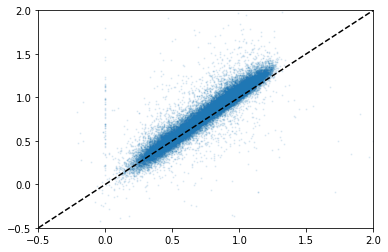

In [8]:
plt.scatter( (gamadf.fitphot_g - gamadf.fitphot_r).reindex(intersection),
            (gamaspec.PETROMAG_G - gamaspec.PETROMAG_R).reindex(intersection), s=1, alpha =0.1 )
plt.xlim(-.5,2.)
plt.ylim(-.5,2.)
plt.plot([-0.5,2.], [-0.5,2.], color='k', ls='--')

In [9]:
gamadf.query('(logmstar<10.)&(z<0.15)').shape

(11478, 94)

In [10]:
gamadf.query('(logmstar<9.6)&(z<0.15)').shape

(6199, 94)

In [11]:
gamadf_int = gamadf.reindex(intersection)

In [12]:
gr = (gamaspec.PETROMAG_G - gamaspec.PETROMAG_R).reindex(intersection)
sb_r = (gamaspec.PETROMAG_R + 2.5*np.log10(2.*np.pi*gamaspec.PETRORAD_R**2)).reindex(intersection)
rmag = gamaspec.reindex(intersection).PETROMAG_R

in_primary = sb_r - 0.7*(rmag - 14.) > 18.5
in_primary &= gr + 0.06*(rmag - 14.) < 0.9

In [13]:
comparison_saga = pd.read_csv('../data/comparison_saga.csv', index_col=0)

In [14]:
gama_rlim =19.4
ml_pct = 0.9

step = .01
zbins = np.arange(0.01,.1,.005)
masslim_z = pd.DataFrame()
masslim_z['zmed'] = zbins
    

gama_masslim = gamadf_int['logmstar'] - 0.4*(gama_rlim - rmag)

for ix,zb in enumerate(zbins):        
    mask = (gamadf_int['z']>(zb-step))&(gamadf_int['z']<=(zb+step))
    mask &= gamadf_int['logmstar'] > gama_masslim

    masslim_z.loc[ix, f'log_sm'] = gama_masslim.loc[mask].quantile(ml_pct)
    masslim_z.loc[ix, f'N'] = mask.sum()

    masslim_z.loc[ix, 'zmin'] = zb-step
    masslim_z.loc[ix, 'zmax'] = zb+step

In [15]:
masslim_z.to_csv('../figures_targeting/gama_masslims.csv')

In [16]:
plt.rcParams['font.size'] = 18

In [17]:
zbins = np.linspace(0.,.2, 10)
saga_ml = comparison_saga.groupby ( np.digitize(comparison_saga['SPEC_Z'], zbins )).quantile(0.025)['log_sm']

In [18]:
gama_ml = gamadf_int.loc[in_primary].groupby ( np.digitize(gamadf_int.loc[in_primary,'z'], zbins )).quantile(0.025)['logmstar']

In [19]:
saga_ml

1     6.70700
2     7.60875
3     8.11050
4     8.42000
5     8.62000
6     8.86150
7     9.03000
8     9.17000
9     9.31000
10    9.45650
Name: log_sm, dtype: float64

In [20]:
gama_ml - saga_ml

1     0.356383
2     0.310078
3     0.332795
4     0.490629
5     0.524272
6     0.395061
7     0.354085
8     0.294969
9     0.243748
10         NaN
dtype: float64

/home/kadofong/extras/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/kadofong/extras/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


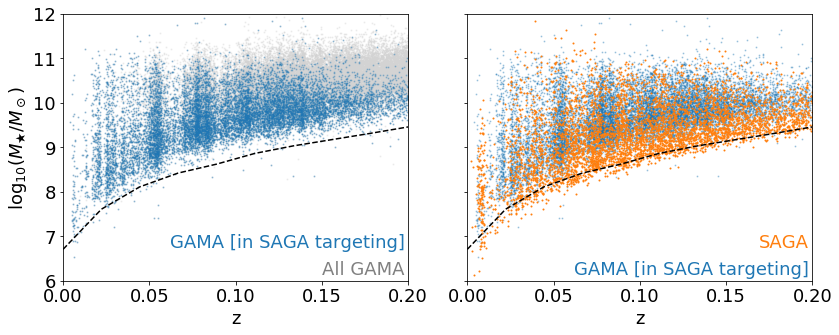

In [21]:
fig, axarr = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True )
axarr[0].scatter ( gamadf_int.loc[:, 'z'], gamadf_int.loc[:, 'logmstar'], s=1, color='lightgrey', alpha=0.3,
                 label='All GAMA', rasterized=True)
axarr[0].scatter ( gamadf_int.loc[in_primary, 'z'], gamadf_int.loc[in_primary, 'logmstar'], s=1, alpha=0.3,
                 label='GAMA [in SAGA targeting]', rasterized=True)
axarr[0].set_ylim(6.,12.)
axarr[0].set_xlim(0.,.2)
axarr[0].text ( 0.99, 0.01, 'All GAMA', transform=axarr[0].transAxes, ha='right', va='bottom', color='grey')
axarr[0].text ( 0.99, 0.11, 'GAMA [in SAGA targeting]', transform=axarr[0].transAxes, 
               ha='right', va='bottom', color='C0')

axarr[1].scatter ( gamadf_int.loc[in_primary, 'z'], gamadf_int.loc[in_primary, 'logmstar'], s=1, alpha=0.3,
                 label='GAMA [in SAGA targeting]', rasterized=True)
axarr[1].scatter ( comparison_saga['SPEC_Z'], comparison_saga['log_sm'], s=1, color='C1',
                 label='SAGA', rasterized=True)
axarr[1].text ( 0.99, 0.01, 'GAMA [in SAGA targeting]', transform=axarr[1].transAxes, 
               ha='right', va='bottom', color='C0')
axarr[1].text ( 0.99, 0.11, 'SAGA', transform=axarr[1].transAxes, 
               ha='right', va='bottom', color='C1')

for ax in axarr:
    ax.plot(zbins, saga_ml, color='k', ls='--')
    #ax.plot(zbins[:-1], gama_ml, color='k', ls=':')


axarr[1].set_ylim(6.,12.)
axarr[1].set_xlim(0.,.2)

axarr[0].set_xlabel('z')
axarr[1].set_xlabel('z')
axarr[0].set_ylabel(r'$\log_{10}(M_\bigstar/M_\odot)$')
plt.tight_layout ()
plt.savefig('../figures_targeting/gamatargeting_sagatargeting.pdf')

In [22]:
gamadf_int['in_saga'] = in_primary

In [102]:
zbins = np.linspace(0.,.2,15)
assns = np.digitize(gamadf_int['z'], zbins)
saga_assns = np.digitize(comparison_saga['SPEC_Z'], zbins)

In [103]:
completeness_df = pd.DataFrame()
completeness_df['grp'] = np.unique(assns)
for masslim in [9.6, 10.]:
    ml = str(np.round(masslim,1))
    for name, grp in gamadf_int.groupby(assns):
        is_dwarf = (grp['logmstar']<masslim)&(grp['logmstar']>6.)
        completeness_df.loc[name-1, f'dwarf_{ml}_completeness'] = grp.loc[is_dwarf, 'in_saga'].sum() / is_dwarf.sum()
        completeness_df.loc[name-1, f'dwarf_{ml}_purity_gama'] = (grp.loc[grp.in_saga,'logmstar']<masslim).sum() / grp.in_saga.sum()

    for name, grp in comparison_saga.groupby(saga_assns):
        if name > (len(zbins)-1):
            continue
        is_dwarf = grp['log_sm'] < masslim
        completeness_df.loc[name-1, f'dwarf_{ml}_purity_saga'] = is_dwarf.sum() / grp.shape[0]

In [111]:
fratio = 3
fsize = 5

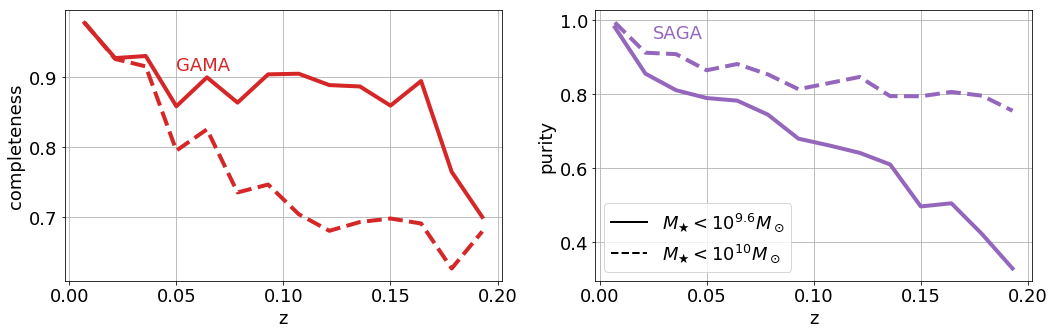

In [112]:
fig, axarr = plt.subplots(1,2,figsize=(fratio*fsize, fsize) )
zmed = zbins[completeness_df['grp']] - np.diff(zbins)[0]/2.
marker_l = ['-', '--']
for marker, ml in zip(marker_l,[9.6,10.]): 
    ml = str(ml)
    axarr[0].plot ( zmed, completeness_df[f'dwarf_{ml}_completeness'],marker, lw=4, color='tab:red')
    axarr[1].plot ( zmed, completeness_df[f'dwarf_{ml}_purity_saga'], marker, lw=4, color='tab:purple')

axarr[0].text(0.05,0.91, 'GAMA', color='tab:red')
axarr[0].set_xlabel('z')
axarr[0].set_ylabel('completeness')

axarr[1].text(0.025, 0.95,'SAGA', color='tab:purple')
#axarr[1].text(0.05, 0.6,'GAMA', color='tab:green', ha='right')
axarr[1].set_xlabel('z')
axarr[1].set_ylabel('purity')

custom_lines = [Line2D([0], [0], color='k', lw=2, linestyle='-'),
                Line2D([0], [0], color='k', lw=2, linestyle='--')]
axarr[1].legend(custom_lines, [r'$M_\bigstar<10^{9.6} M_\odot$', r'$M_\bigstar<10^{10} M_\odot$'],
               loc='lower left')

for ax in axarr:
    ax.grid()
    
plt.tight_layout()
plt.savefig('../figures_targeting/gamapurity_sagatargeting.pdf')